<a href="https://colab.research.google.com/github/sheemambabu/CMPE-258-Deep-Learning/blob/main/Assignment%204/%20Assignment_4_Part1%262.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CMPE-258 Deep Learning**

## Assignment 4

## By: Sheema Murugesh Babu (SJSU_ID: 015217176)



Assignment Description: Implementing a MNIST classifier with various training knobs with numpy and keras.

*Note: Some of the code (especially the ones where I build the neural network architecture from scratch in numpy) have been reused from the previous assignment and modified according to this assignment's requirement. Also, all the links to the pages refered are mentioned in the references section.* 

# Importing the basic libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Loading the MNIST data from keras.

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x train:', x_train.shape)
print('y train:', y_train.shape)
print('x test:', x_test.shape)
print('y test:', y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
x train: (60000, 28, 28)
y train: (60000,)
x test: (10000, 28, 28)
y test: (10000,)


In the above output, we can see that the it is structured as a 3 dimensional array of instances, image-width and image-height.

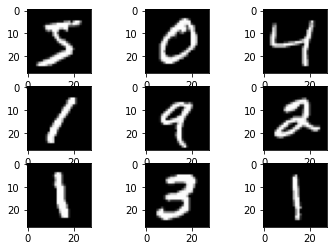

In [ ]:
# create a grid of 3x3 images
for i in range(0, 9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [ ]:
# Scaling and Normalizing
# Reducing the 28*28 images to a 784 vector for each image.

num_pixels = x_train.shape[1] * x_train.shape[2]
X_train = x_train.reshape((x_train.shape[0], num_pixels)).astype('float32')
X_test = x_test.reshape((x_test.shape[0], num_pixels)).astype('float32')

print('X train:', X_train.shape)
print('X test:', X_test.shape)

X train: (60000, 784)
X test: (10000, 784)


In [ ]:
# Normalizing the inputs (x data)

X_train = X_train / 255
X_test = X_test / 255

In [ ]:
from keras.utils import np_utils

# One hot coding the outputs (y data)
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)
num_classes = Y_test.shape[1]

# print(Y_train[0])
print('No of classes:', num_classes)
print('Y train:', Y_train.shape)
print('Y test:', Y_test.shape)

No of classes: 10
Y train: (60000, 10)
Y test: (10000, 10)


# Training the dataset using augmentation

In [ ]:
aug_X_train= x_train[0:500]
aug_y_train = y_train[0:500]

aug_X_train = aug_X_train.reshape(-1,28,28,1)
aug_X_train.shape

(500, 28, 28, 1)

In [ ]:
# Implemeting the Keras Datagen refered from 
# https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6 

from keras.preprocessing.image import ImageDataGenerator

datagen_sample = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False) 

datagen_sample.fit(aug_X_train)

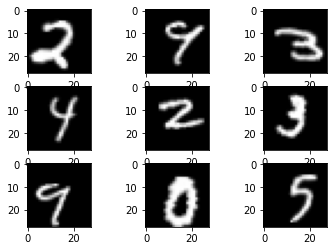

In [ ]:
# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen_sample.flow(aug_X_train, aug_y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

After running the image augmentation we can see there are changes in the above two images and the most recent image has underfone some changes and looks more clearer. 

# Part 1: Implementing MNIST classifier using Numpy

The assignment is to implement MNIST classifier fully with all the things learnt in last class with many features in numpy in a colab.

## Building a neural network from scratch


In [ ]:
# Mean Squared Error

class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient

In [ ]:
# Relu Activation layer

class Relu:
  def __init__(self):
    self.input = np.array([])

  def forward(self, input):
    self.input = input.copy()
    self.output = np.clip(self.input, 0, None)
    return self.output
  
  def predict(self, input):
    return np.clip(input, 0, None)
    
  def backward(self, upstr_gradient):
    return (self.input > 0) * upstr_gradient
  
  def update(self, lr):
    return

  def __str__(self):
    return 'ReLu'

In [ ]:
class Layer:
  def __init__(self, n_input_nodes=1, n_output_nodes=1, activation_func=None):
    self.n_input_nodes = n_input_nodes
    self.n_output_nodes = n_output_nodes

    # Idea refered from https://github.com/iamtrask/Grokking-Deep-Learning/blob/master/Chapter8%20-%20Intro%20to%20Regularization%20-%20Learning%20Signal%20and%20Ignoring%20Noise.ipynb
    self.weights = 0.2 * np.random.random((n_input_nodes, n_output_nodes)) - 0.1
    self.bias = 0.2 * np.random.random((1)) - 0.1
    self.X = np.zeros([n_input_nodes])

    if activation_func == 'relu':
      self.activation_func = Relu()
    else: 
      self.activation_func = None
  
  # For adding dropouts, idea refered from https://wiseodd.github.io/techblog/2016/06/25/dropout/
  def forward(self, X, dpt):
    self.X = X.copy()
    self.Z = X @ self.weights + self.bias
    
    if self.activation_func == None:
      return self.Z 
    else:
      wgts_dpt = np.random.binomial(1, dpt, size=self.Z.shape) / dpt
      return self.activation_func.forward(self.Z) * wgts_dpt

  def predict (self, X):
    if self.activation_func == None:
      return X @ self.weights + self.bias
    else:
      return self.activation_func.predict(X @ self.weights + self.bias)

  def backward(self, upstr_gradient):
    current_upstr_gradient = upstr_gradient.copy()
    if self.activation_func != None:
      current_upstr_gradient = self.activation_func.backward(current_upstr_gradient)
    
    self.dJdW = self.X.T @ current_upstr_gradient
    self.dJdb = current_upstr_gradient.sum()
    self.dJdX = current_upstr_gradient @ self.weights.T
    return self.dJdX

  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    return 'Layer: ({},{})'.format(self.n_input_nodes, self.n_output_nodes)

In [ ]:
from sklearn.metrics import mean_squared_error

class NeuralNetwork_Model:
  def __init__(self, n_inputs=3, n_hidden=[2], n_outputs=2, activation_func=None):
    self.n_inputs = n_inputs
    self.n_hidden = n_hidden
    self.n_outputs = n_outputs

    layers = [self.n_inputs] + self.n_hidden + [self.n_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      # Not adding the activation function to last layer because it is a regression problem
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation_func=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation_func))

    print('Neural Network Architecture:')
    for i, layer in enumerate(self.layers):
      print('---------------------- Layer {} ----------------------'.format(i))
      print(layer)
    print()

  def forward(self, inputs, dpt):
    current_output = inputs.copy()
    for l in self.layers:
      current_output = l.forward(current_output, dpt)
    return current_output
  
  def predict(self, inputs):
    current_output = inputs.copy()
    for l in self.layers:
      current_output = l.predict(current_output)
    return current_output 

  def backward(self, y_pred, y_true):
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    # print('MSE: ', mean_squared_error(y_true, y_pred))
    loss_gradient = mse.backward()
    gradient = loss_gradient.copy()
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  # The below idea for coding the fit function has been refered from
  # https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
  def fit(self, datagen, X_train_aug, X_train, y_train, X_test, y_test,epochs, batch_size, dpt):
    # For metrics
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    for e in range(epochs):
      if (e%10 == 0):
        mini_batch = 0
        # Tying the above implemented datagen.flow to each iteration.
        for x_batch, y_batch in datagen.flow(X_train_aug, y_train, batch_size=batch_size):
          X_train_2 = x_batch.reshape(x_batch.shape[0], num_pixels) / 255.
          y_pred = self.forward(X_train_2, dpt)
          self.backward(y_pred, y_batch)
          self.update(lr)

          if mini_batch >= len(X_train_aug) / batch_size:
            break
          mini_batch += 1

        # Metrics
        y_pred = self.predict(X_train)
        train_loss_v = mean_squared_error(y_train, y_pred)
        train_loss.append(train_loss_v)
        train_accuracy_v = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
        train_accuracy.append(train_accuracy_v)

        y_pred = self.predict(X_test)
        test_loss_v = mean_squared_error(y_test, y_pred)
        test_loss.append(test_loss_v)
        test_accuracy_v = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        test_accuracy.append(test_accuracy_v)

        print('I: {} Train-Loss: {} Train-Accuracy: {} Test-Loss: {} Test-Accuracy: {}'. format(e, np.round(train_loss_v,4), np.round(train_accuracy_v,4), np.round(test_loss_v, 4), np.round(test_accuracy_v, 4)))

    return train_loss, train_accuracy, test_loss, test_accuracy

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

# Hyperparameters

In [ ]:
# Number of Iterations
epochs = 450

# Learning rate of the algorithm
lr = 0.006

# Specify batch size
batch_size = 128

# Specifying dropouts
dpt_1 = 0.5
dpt_2 = 0.8

# Input and output size.
input = X_train.shape[1]
output = Y_train.shape[1]

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

X_train_aug = x_train.reshape(-1,28,28,1)

print(X_train_aug.shape)
print(input)
print(output)
print(X_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(Y_train.shape)

(60000, 28, 28, 1)
784
10
(60000, 784)
(10000, 784)
(10000, 10)
(60000, 10)


# Training the Neural Network model with dropout 1 i.e 0.5

In [ ]:
model_1 = NeuralNetwork_Model(n_inputs=input, n_hidden=[128, 64], n_outputs=output, activation_func='relu')
train_loss, train_accuracy, test_loss, test_accuracy = model_1.fit(datagen, X_train_aug, X_train, Y_train, X_test, Y_test, epochs, batch_size, dpt_1)

Neural Network Architecture:
---------------------- Layer 0 ----------------------
Layer: (784,128)
---------------------- Layer 1 ----------------------
Layer: (128,64)
---------------------- Layer 2 ----------------------
Layer: (64,10)

I: 0 Train-Loss: 0.0822 Train-Accuracy: 0.4819 Test-Loss: 0.0819 Test-Accuracy: 0.4944
I: 10 Train-Loss: 0.0768 Train-Accuracy: 0.5907 Test-Loss: 0.0764 Test-Accuracy: 0.6063
I: 20 Train-Loss: 0.0761 Train-Accuracy: 0.5905 Test-Loss: 0.0757 Test-Accuracy: 0.5966
I: 30 Train-Loss: 0.0765 Train-Accuracy: 0.5901 Test-Loss: 0.0762 Test-Accuracy: 0.5987
I: 40 Train-Loss: 0.0763 Train-Accuracy: 0.5862 Test-Loss: 0.076 Test-Accuracy: 0.5935
I: 50 Train-Loss: 0.076 Train-Accuracy: 0.6016 Test-Loss: 0.0757 Test-Accuracy: 0.6137
I: 60 Train-Loss: 0.0754 Train-Accuracy: 0.5553 Test-Loss: 0.0751 Test-Accuracy: 0.5698
I: 70 Train-Loss: 0.0752 Train-Accuracy: 0.5155 Test-Loss: 0.0748 Test-Accuracy: 0.5264
I: 80 Train-Loss: 0.0752 Train-Accuracy: 0.4754 Test-Loss: 

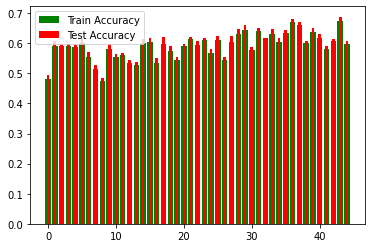

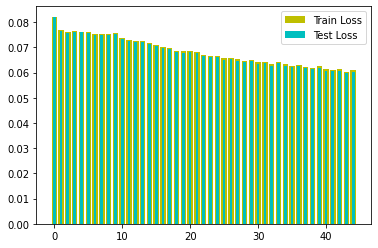

In [ ]:
plt.bar(range(len(train_accuracy)), train_accuracy, align='center', width=0.8, color='g', label='Train Accuracy')
plt.bar(range(len(test_accuracy)), test_accuracy, align='center', width=0.4, color='r', label='Test Accuracy')
plt.legend()

plt.figure()
plt.bar(range(len(train_loss)), train_loss, align='center', width=0.8, color='y', label='Train Loss')
plt.bar(range(len(test_loss)), test_loss, align='center', width=0.4, color='c', label='Test Loss')
plt.legend()
plt.show()

In [ ]:
# Confusion Matrix 
import itertools
from sklearn.metrics import confusion_matrix
# Refered from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

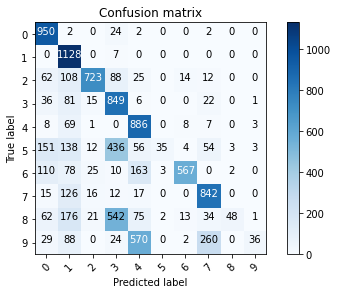

In [ ]:
y_pred = model_1.predict(X_test)
confusion_mtx = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, list(range(0, 10)))

# Training the Neural Network model with dropout 2 i.e 0.8

In [ ]:
model_2 = NeuralNetwork_Model(n_inputs=input, n_hidden=[128, 64], n_outputs=output, activation_func='relu')
train_loss_2, train_accuracy_2, test_loss_2, test_accuracy_2 = model_2.fit(datagen, X_train_aug, X_train, Y_train, X_test, Y_test, epochs, batch_size, dpt_2)

Neural Network Architecture:
---------------------- Layer 0 ----------------------
Layer: (784,128)
---------------------- Layer 1 ----------------------
Layer: (128,64)
---------------------- Layer 2 ----------------------
Layer: (64,10)

I: 0 Train-Loss: 0.0807 Train-Accuracy: 0.4337 Test-Loss: 0.0805 Test-Accuracy: 0.441
I: 10 Train-Loss: 0.0693 Train-Accuracy: 0.6179 Test-Loss: 0.0689 Test-Accuracy: 0.6296
I: 20 Train-Loss: 0.0639 Train-Accuracy: 0.6999 Test-Loss: 0.0635 Test-Accuracy: 0.7149
I: 30 Train-Loss: 0.0608 Train-Accuracy: 0.7258 Test-Loss: 0.0603 Test-Accuracy: 0.7477
I: 40 Train-Loss: 0.0586 Train-Accuracy: 0.7404 Test-Loss: 0.0581 Test-Accuracy: 0.7585
I: 50 Train-Loss: 0.0561 Train-Accuracy: 0.7407 Test-Loss: 0.0555 Test-Accuracy: 0.7637
I: 60 Train-Loss: 0.0536 Train-Accuracy: 0.739 Test-Loss: 0.0529 Test-Accuracy: 0.7538
I: 70 Train-Loss: 0.0517 Train-Accuracy: 0.7401 Test-Loss: 0.051 Test-Accuracy: 0.7547
I: 80 Train-Loss: 0.0497 Train-Accuracy: 0.7541 Test-Loss: 0

Observation: At dropout at '0.8' we see that the accuracies have increased than the dropout at '0.5'.

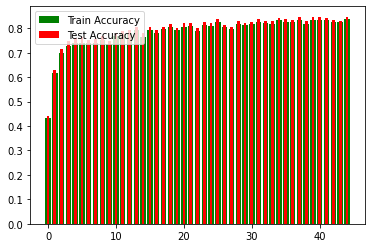

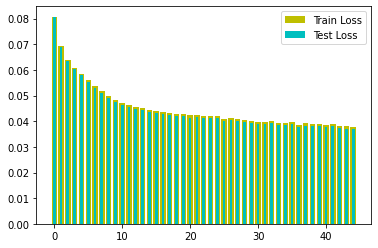

In [ ]:
plt.bar(range(len(train_accuracy_2)), train_accuracy_2, align='center', width=0.8, color='g', label='Train Accuracy')
plt.bar(range(len(test_accuracy_2)), test_accuracy_2, align='center', width=0.4, color='r', label='Test Accuracy')
plt.legend()

plt.figure()
plt.bar(range(len(train_loss_2)), train_loss_2, align='center', width=0.8, color='y', label='Train Loss')
plt.bar(range(len(test_loss_2)), test_loss_2, align='center', width=0.4, color='c', label='Test Loss')
plt.legend()
plt.show()

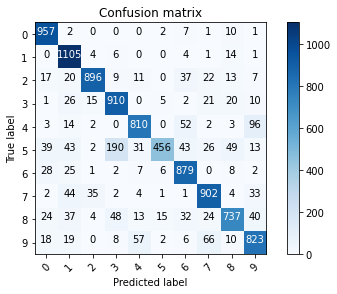

In [ ]:
y_pred = model_2.predict(X_test)
confusion_mtx_2 = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_2, list(range(0, 10)))

# Part 1: Implementing MNIST classifier using Keras

In [ ]:
# Importing the necessary libraries.

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten

In [ ]:
# Refered from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

# Number of Iterations
epochs = 20

# Learning rate of the algorithm
lr = 0.01

# Specify batch size
batch_size = 128

# Input and output size.
input = X_train.shape[1]
output = Y_train.shape[1]

X_train_aug = x_train.reshape(-1,28,28,1)
X_test_aug = x_test.reshape(-1, 28, 28, 1)

print(X_train_aug.shape)
print(X_test_aug.shape)
print(input)
print(output)


(60000, 28, 28, 1)
(10000, 28, 28, 1)
784
10


In [ ]:
# Image augmentations for Keras Model
datagen_keras = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen_keras.fit(X_train_aug)

In [ ]:
# Baseline Model
num_classes = 10

def baseline_model():
  model = Sequential()
  model.add(Dense(784, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax'))
  # Compile model
  # Refered from https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr), metrics=['accuracy'])
  return model

In [ ]:
model = baseline_model()

# Refered from https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
history = model.fit(
            datagen_keras.flow(X_train_aug, Y_train, batch_size=batch_size),
            steps_per_epoch=X_train_aug.shape[0] // batch_size,
            epochs = epochs,
            validation_data = datagen_keras.flow(X_test_aug, Y_test, batch_size=batch_size),
            validation_steps = X_test_aug.shape[0] // batch_size
            )

Epoch 1/20
468/468 [==============================] - 72s 153ms/step - loss: 5.1817 - accuracy: 0.4660 - val_loss: 0.4847 - val_accuracy: 0.8528
Epoch 2/20
468/468 [==============================] - 73s 155ms/step - loss: 0.6496 - accuracy: 0.7982 - val_loss: 0.3721 - val_accuracy: 0.8961
Epoch 3/20
468/468 [==============================] - 74s 157ms/step - loss: 0.5406 - accuracy: 0.8323 - val_loss: 0.3360 - val_accuracy: 0.9064
Epoch 4/20
468/468 [==============================] - 74s 159ms/step - loss: 0.4837 - accuracy: 0.8504 - val_loss: 0.2851 - val_accuracy: 0.9168
Epoch 5/20
468/468 [==============================] - 74s 159ms/step - loss: 0.4570 - accuracy: 0.8587 - val_loss: 0.2743 - val_accuracy: 0.9199
Epoch 6/20
468/468 [==============================] - 74s 159ms/step - loss: 0.4183 - accuracy: 0.8726 - val_loss: 0.2541 - val_accuracy: 0.9286
Epoch 7/20
468/468 [==============================] - 74s 159ms/step - loss: 0.4102 - accuracy: 0.8746 - val_loss: 0.2436 - val_ac

Validation Accuracy is 95%.

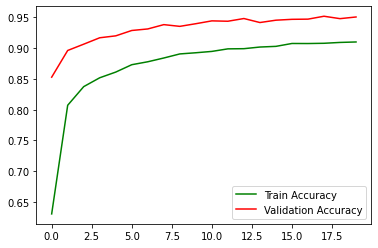

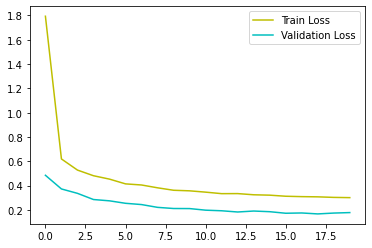

In [ ]:
plt.plot(history.history['accuracy'], color='g', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], color='y', label='Train Loss')
plt.plot(history.history['val_loss'], color='c', label='Validation Loss')
plt.legend()

## References :

1) Class Slides <br>
2) https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9 <br>
3) https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html <br>
4) https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/ <br>
5) https://github.com/kdexd/digit-classifier <br>
6) https://github.com/kdexd/digit-classifier/blob/master/network.py <br>
7) https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6 <br>
8) https://machinelearningmastery.com/image-augmentation-deep-learning-keras/